# Evaluation of Pre-Trained Model
Load in a model(s) of your choice and evaluate.

## Imports

In [1]:
#basics
import numpy as np
import matplotlib.pyplot as plt

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler

#Torchvision
import torchvision
from torchvision import transforms, datasets

#Data
from MiraBest import MiraBest_full

#My Functions / Models
from models_new import *
#from evaluations import *

#Other
import PIL
from torchsummary import summary
from models.networks_other import init_weights
from mpl_toolkits.axes_grid1 import ImageGrid

## Importing Data

In [2]:
test_transform = transforms.Compose([transforms.RandomRotation([0,360],resample=PIL.Image.BILINEAR),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5],[0.5])
                                     ])
out_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5],[0.5])
                                    ])
train_transform = transforms.Compose([transforms.RandomRotation([0,360],resample=PIL.Image.BILINEAR),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5],[0.5])
                                     ])
#Reminder to try transformations different for each data set, eg:
#transformtrain = transforms.Compose([transforms.ToTensor()])
#transformtest = transforms.Compose([transforms.ToTensor()])

In [3]:
def Sampler(trainset, valid_size = 0.,allowed_labels=[0,1,2,3,4,5,6,7,8,9]):
    # Obtain training indices that will be used for validation
    indices = []
    # Filter out all unwanted data before batching
    for batch_idx, (data,label) in enumerate(trainset):
        if label in allowed_labels:
            indices.append(batch_idx)
            
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * len(indices)))
    train_idx, valid_idx = indices[split:], indices[:split]
    print(f"Samples retained: {len(indices)} of {len(trainset)} with allowed_labels = {allowed_labels}")
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    return (train_sampler, valid_sampler)

In [4]:
dataset_name = 'MiraBest'

if dataset_name == 'MNIST':
    pass
    #traindata = datasets.MNIST('', train = True, download = True, transform=transform)
    #testdata = datasets.MNIST('', train = False, download = True, transform = transform)
elif dataset_name == 'FRDEEPF':
    traindata = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=out_transform)
    testdata = FRDEEPF(root='./FIRST_data', train=False, download=True, transform=out_transform)
    outdata = FRDEEPF(root='./FIRST_data', train=False, download=True, transform=out_transform)
elif dataset_name == 'MiraBest':
    traindata = MiraBest_full(root='./FIRST_data', train=True, download=True, transform=out_transform)
    testdata = MiraBest_full(root='./FIRST_data', train=False, download=True, transform=out_transform)
    outdata = MiraBest_full(root='./FIRST_data', train=False, download=True, transform=out_transform)
else:
    raise NotImplementedError

counter=0
for data in traindata:
    counter+=1
print(f'{counter} samples in the traindata: traindata.shape: {data[1]},{data[0].shape}')

counter=0
for data in testdata:
    counter+=1
print(f'{counter} samples in the testdata: testdata.shape: {data[1]},{data[0].shape}')

counter=0
for data in outdata:
    counter+=1
print(f'{counter} samples in the outdata: outdata.shape: {data[1]},{data[0].shape}')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
1099 samples in the traindata: traindata.shape: 9,torch.Size([1, 150, 150])
157 samples in the testdata: testdata.shape: 9,torch.Size([1, 150, 150])
157 samples in the outdata: outdata.shape: 9,torch.Size([1, 150, 150])


In [5]:
batch_size = 16
valid_size = 0.2
allowed_labels = range(10)[:-2]

train_sampler,valid_sampler = Sampler(traindata, valid_size=valid_size,allowed_labels=allowed_labels)

outset = torch.utils.data.DataLoader(outdata, batch_size=batch_size)
trainset = torch.utils.data.DataLoader(traindata, batch_size=batch_size)
validset = torch.utils.data.DataLoader(traindata, batch_size=batch_size)
testset = torch.utils.data.DataLoader(testdata, batch_size=batch_size, shuffle=False)

Samples retained: 1069 of 1099 with allowed_labels = range(0, 8)


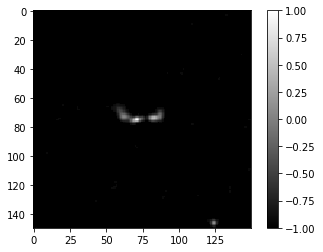

In [6]:
# Helpful dimensionality visualisation on input values.
for batch in outset:
    plt.imshow(batch[0][0].view(150,150),cmap='gray')
    plt.colorbar()
    break
#testdata = torch.randn(1,1,150,150)
#plt.imshow(testdata[0][0].view(150,150))

# Histogram of Data Distributions By Class

In [7]:
# Import all images and seperate them by their labels
fri = []
frii = []
fri_labels = []
frii_labels = []
count=0
# First from testingset (same as outset)
for data in iter(outset):
    images_temp , labels_temp = data
    images_np = images_temp.numpy()
    labels_np = labels_temp.numpy()
    print(labels_temp,labels_np)
    for i in range(labels_np.shape[0]):
        count+=1
        if labels_np[i]==0: #FRI
            fri.append(images_np[i])
            fri_labels.append(labels_np[i])
        elif labels_np[i]==1: #FRII
            frii.append(images_np[i])
            frii_labels.append(images_np[i])

# Now for the training set (validation set has not been removed)
for data in iter(trainset):
    images_temp, labels_temp = data
    images_np = images_temp.numpy()
    labels_np = labels_temp.numpy()
    for i in range(labels_np.shape[0]):
        count+=1
        if labels_np[i] in [0,1,2,3,4]: #FRI
            fri.append(images_np[i])
            fri_labels.append(labels_np[i])
        elif labels_np[i] in [5,6,7]: #FRII
            frii.append(images_np[i])
            frii_labels.append(images_np[i])

print(np.asarray(fri).shape,np.asarray(frii).shape)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]) [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 5, 5]) [3 3 3 3 3 3 3 3 3 4 5 5 5 5 5 5]
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]) [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]) [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]) [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
tensor([6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]) [6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 9, 9]) [7 7 7 7 7 7 7 7 7 8 8 9 9]
(559, 1, 150, 150) (558, 1, 150, 150)


In [8]:
# Prints and Assignments to clean variables
print(f'{len(fri):3} FRI and {len(frii):3} FRII of {count} total sources')
# Create single sorted array of images with one random image as a buffer (to help seperate the sources)
fri = np.asarray(fri).squeeze()
frii = np.asarray(frii).squeeze()
buffer = np.random.rand(1,150,150)
temp = np.append(fri,buffer,axis=0)
fr_all_sorted = np.append(temp,frii,axis=0)
fr_all = np.append(fri,frii,axis=0)
# Rescale Images to [0,1]
fr_all_sorted = fr_all_sorted*0.5+0.5

559 FRI and 558 FRII of 1256 total sources


/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


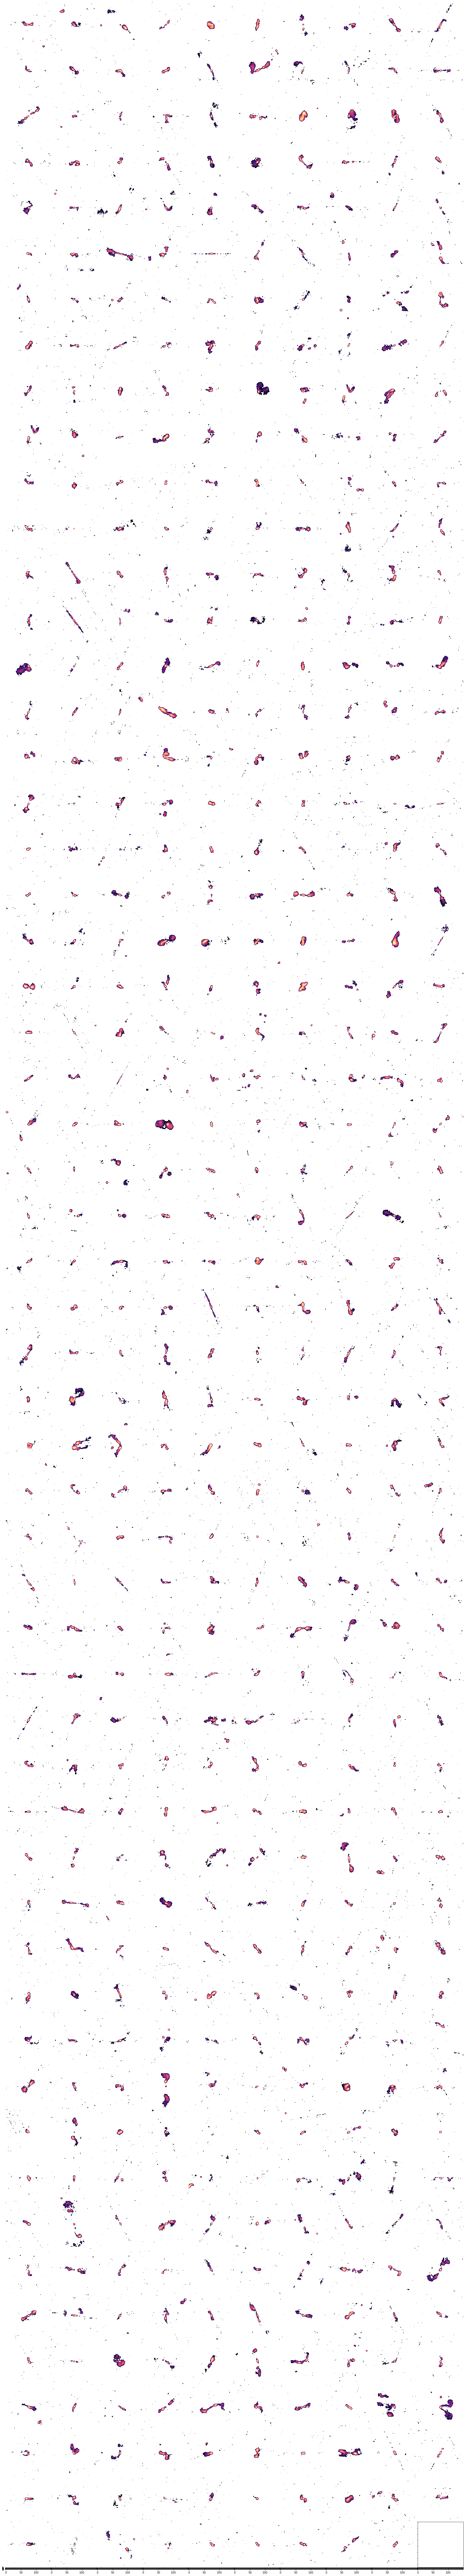

In [9]:
# Define the plot of the grid of images
logged=True

fig = plt.figure(figsize=(30, 300))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(600//10,10),#Sets size of array of images
                 axes_pad=0.01,  # pad between axes (inch).
                 )
for ax, im in zip(grid, fr_all_sorted[:559]):
    # Iterating over the grid returns the Axes.
    if logged:
        ax.imshow(np.log(im),cmap='magma')
    else:
        ax.imshow(im,cmap='magma')
    ax.axis('off')
plt.show()

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


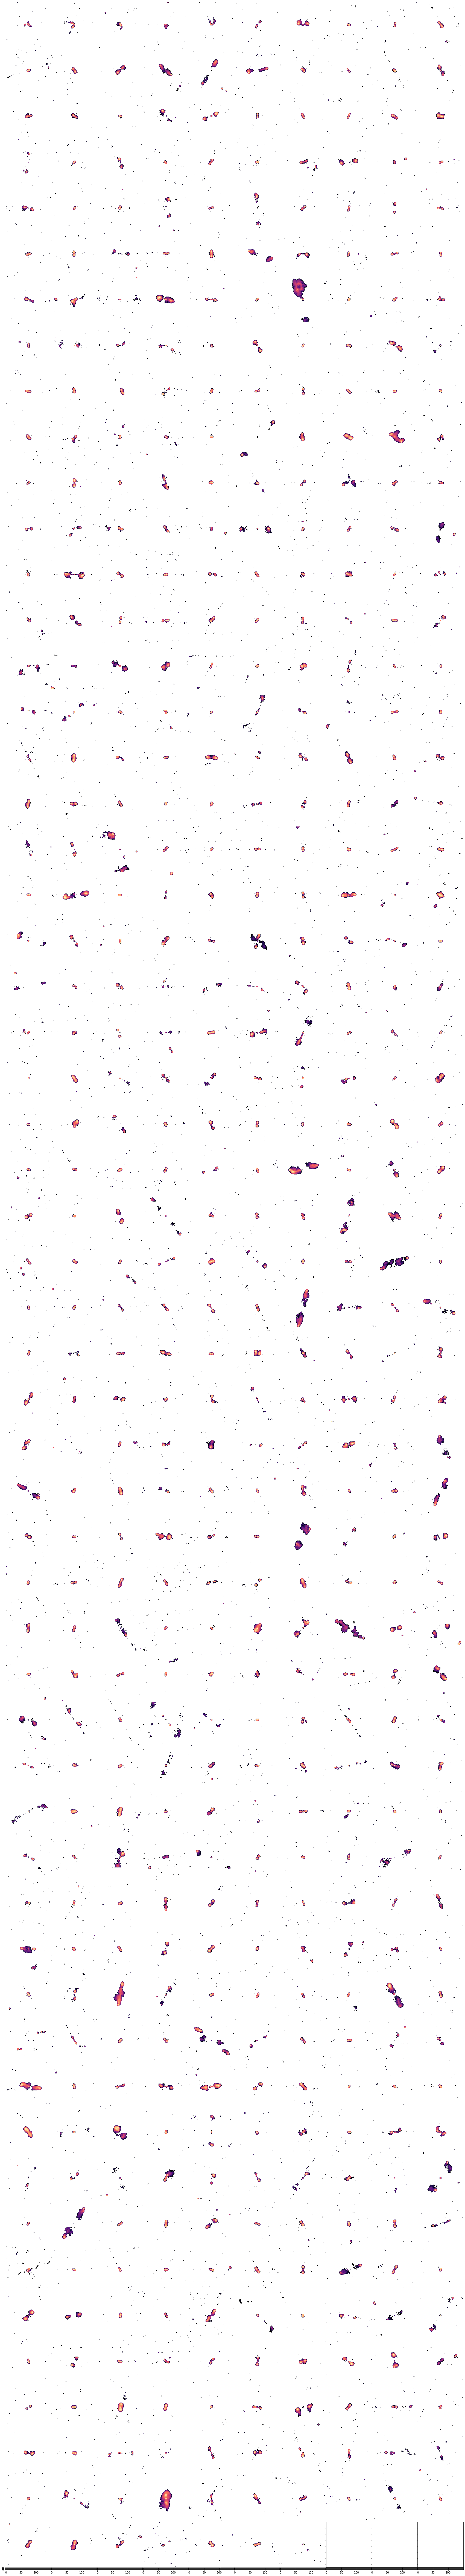

In [10]:
# Define the plot of the grid of images
logged=True

fig = plt.figure(figsize=(30, 300))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(600//10,10),#Sets size of array of images
                 axes_pad=0.01,  # pad between axes (inch).
                 )
for ax, im in zip(grid, fr_all_sorted[561:]):
    # Iterating over the grid returns the Axes.
    if logged:
        ax.imshow(np.log(im),cmap='magma')
    else:
        ax.imshow(im,cmap='magma')
    ax.axis('off')
plt.show()

In [11]:
# Radial sum
def radial_sum(images):
    """
    args: 
        images - 3 dimensional array of images of dimension images.shape[1] by images.shape[2] (0th dimension is the various images to be summed over)
    out:
        scaled sum of values based on distance from the centre of the image (and how many images have been provided)
        array listing the radius at of the value of the given sum (ie. at radius[0] sum is out[0])
    """
    out = []
    radius = []
    r_temp = 0
    print(f'Shape of the given input: {images.shape}')
    for r in range(int(np.sqrt(images.shape[1]**2+images.shape[2]**2))):
        value_temp = 0
        for i in range(images.shape[1]):
            for j in range(images.shape[2]):
                if r**2>(i-images.shape[1]//2)**2+(j-images.shape[2]//2)**2 and r_temp**2<(i-images.shape[1]//2)**2+(j-images.shape[2]//2)**2:
                    value_temp += np.sum((images[:,i,j]+1)/2)
        radius.append(r)
        out.append(value_temp)
        r_temp=r
    return np.asarray(out)/images.shape[0], np.asarray(radius)

In [12]:
fr_all_radial_sums, fr_all_radius = radial_sum(fr_all)
fri_radial_sums, fri_radius = radial_sum(fri)
frii_radial_sums, frii_radius = radial_sum(frii)

Shape of the given input: (1117, 150, 150)
Shape of the given input: (559, 150, 150)
Shape of the given input: (558, 150, 150)


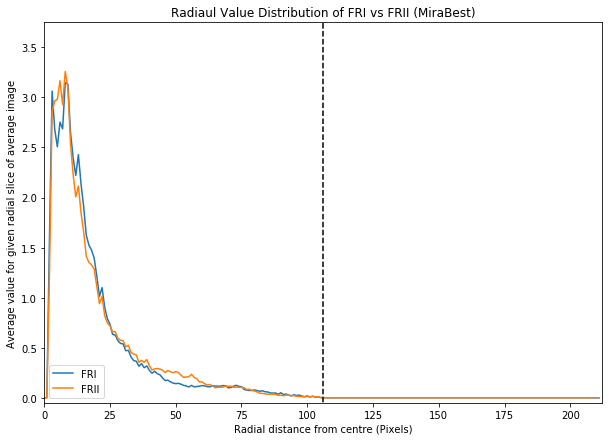

In [13]:
start = [np.sqrt(75**2+75**2),np.sqrt(75**2+75**2)]
end = [-50,200]

plt.figure(figsize=(10,7))

plt.title('Radiaul Value Distribution of FRI vs FRII (MiraBest)')
plt.plot(fri_radius,fri_radial_sums)#,fr_all_radial_sums)
plt.plot(frii_radius,frii_radial_sums)#,fr_all_radial_sums)
plt.plot(start,end,c='k',linestyle='dashed')
#plt.plot(fr_all_radius,fr_all_radial_sums)
plt.xlabel('Radial distance from centre (Pixels)')
plt.ylabel('Average value for given radial slice of average image')
plt.xlim(0,np.sqrt(150**2+150**2))
plt.ylim(-0.05,3.75)
#plt.plot(fr_all_radius,fr_all_radial_sums)
plt.legend(['FRI','FRII'],loc='lower left')

plt.show()

In [14]:
print(f'FRI Integration: {np.trapz(fri_radial_sums[20:])}')
print(f'FRII Integration: {np.trapz(frii_radial_sums[20:])}')

FRI Integration: 17.833592482884157
FRII Integration: 19.47092533325209


In [15]:
def cummulative_sum(array):
    """
    args:
        array of sorted time / location dependant data
    out:
        array of cummulative data
    """
    out = []
    temp = 0
    for i in array:
        temp += i
        out.append(temp)
    return out

# Cumulative Brightness Plot
fri_cummulative = cummulative_sum(fri_radial_sums)
frii_cummulative = cummulative_sum(frii_radial_sums)

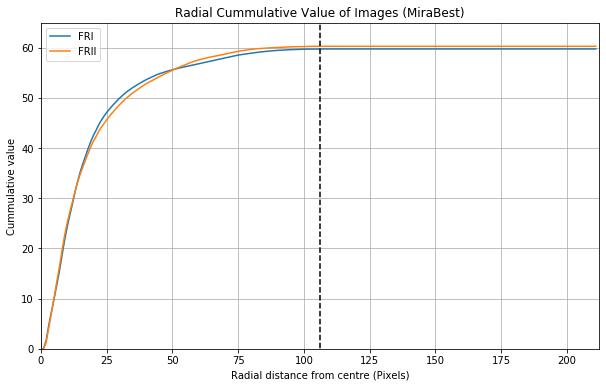

Images are normalised from 0 to 1.
The average total brightness of each FRI image is:  59.8
The average total brightness of each FRII image is: 60.3


In [16]:
plt.figure(figsize=(10,6))
plt.title('Radial Cummulative Value of Images (MiraBest)')
plt.xlabel('Radial distance from centre (Pixels)')
plt.ylabel('Cummulative value')
plt.xlim(0,np.sqrt(150**2+150**2))
plt.ylim(0,65)
plt.grid()
plt.plot(fri_cummulative)
plt.plot(frii_cummulative)
plt.plot(start,end,c='k',linestyle='dashed')
plt.legend(['FRI','FRII'])
plt.show()
print(
f"""Images are normalised from 0 to 1.
The average total brightness of each FRI image is:  {fri_cummulative[-1]:.1f}
The average total brightness of each FRII image is: {frii_cummulative[-1]:.1f}""")

## Create dictionary of all images according to their labels.

In [17]:
full_data = [traindata,outdata,testdata]

temp=[[],[],[],[],[],[],[],[],[],[],[],[]]
for data in full_data[:-1]:
    for image, label in data:
        temp[label].append(image.cpu().numpy())

class_sizes = []
for i in range(10):
    class_sizes.append(len(temp[i]))
print(class_sizes,np.asarray(class_sizes).sum())

[339, 49, 9, 191, 3, 432, 4, 195, 19, 15] 1256


In [18]:
MB_dict = dict()
MB_dict['FRI_standard'] = np.asarray(temp[0])
MB_dict['FRI_WAT']=np.asarray(temp[1])
MB_dict['FRI_Diffuse']=np.NaN
MB_dict['FRI_HT']=np.asarray(temp[2])
MB_dict['FRI_unc_standard']=np.asarray(temp[3])
MB_dict['FRI_unc_WAT']=np.asarray(temp[4])

MB_dict['FRII_standard']=np.asarray(temp[5])
MB_dict['FRII_dd']=np.asarray(temp[6])
MB_dict['FRII_unc_Standard']=np.asarray(temp[7])

MB_dict['Hybrid']=np.asarray(temp[8])
MB_dict['Hybrid_unc']=np.asarray(temp[9])

## Looking to calculate the radial sum of the images for subsets of certain vs all. See if it matches HM distribution at all.

In [19]:
# Radial sum
def radial_sum(images,normalization='individual'):
    """
    args: 
        images - 3 dimensional array of images of dimension images.shape[1] by images.shape[2] (0th dimension is the various images to be summed over)
    out:
        scaled sum of values based on distance from the centre of the image (and how many images have been provided)
        array listing the radius at of the value of the given sum (ie. at radius[0] sum is out[0])
    """
    
    out = []
    radius = []
    r_temp = 0
    print(f'Shape of the given input: {images.shape}')
    for r in range(int(np.sqrt(images.shape[1]**2+images.shape[2]**2))):
        value_temp = 0
        for i in range(images.shape[1]):
            for j in range(images.shape[2]):
                if r**2>(i-images.shape[1]//2)**2+(j-images.shape[2]//2)**2 and r_temp**2<(i-images.shape[1]//2)**2+(j-images.shape[2]//2)**2:
                    value_temp += np.sum((images[:,i,j]+1)/2)
        radius.append(r)
        out.append(value_temp)
        r_temp=r
    if normalization == 'individual':
        return np.asarray(out)/images.shape[0], np.asarray(radius)
    elif normalization == 'MiraBest_classes':
        return np.asarray(out)/1413, np.asarray(radius)
    else:
        return np.asarray(out), np.asarray(radius)
        

In [20]:
list_plot = []
names_plot = []
for c, ims in MB_dict.items():
    if type(ims) != type(np.array(0)):
        pass
    else:
        rad_sum, rad = radial_sum(ims.squeeze(),normalization='MiraBest_classes')
        list_plot.append(rad_sum)
        names_plot.append(c)

Shape of the given input: (339, 150, 150)
Shape of the given input: (49, 150, 150)
Shape of the given input: (9, 150, 150)
Shape of the given input: (191, 150, 150)
Shape of the given input: (3, 150, 150)
Shape of the given input: (432, 150, 150)
Shape of the given input: (4, 150, 150)
Shape of the given input: (195, 150, 150)
Shape of the given input: (19, 150, 150)
Shape of the given input: (15, 150, 150)


In [21]:
print(f'FRI have: {339+49+9+191+3}\nFRII have: {432+4+195}\nFRII with hybrids have: {19+15+432+4+195}')

FRI have: 591
FRII have: 631
FRII with hybrids have: 665


In [22]:
def cummulative_sum(array):
    """
    args:
        array of sorted time / location dependant data
    out:
        array of cummulative data
    """
    out = []
    temp = 0
    for i in array:
        temp += i
        out.append(temp)
    return np.asarray(out)

# Cumulative Brightness Plot
list_plot_cum = []
for i in range(len(names_plot)):
    list_plot_cum.append(cummulative_sum(list_plot[i]))


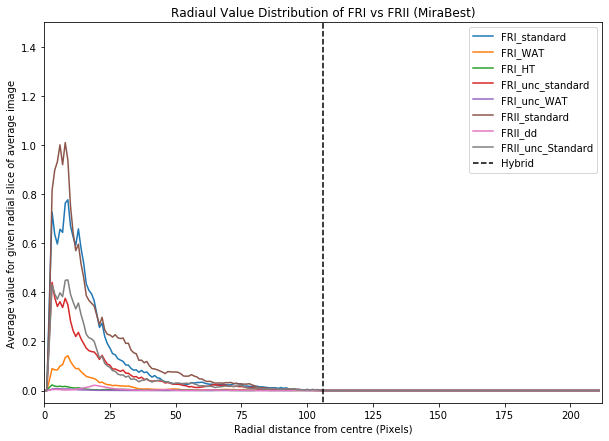

In [23]:
radii = []
for i in range(10):
    radii.append(np.array(rad))

start = [np.sqrt(75**2+75**2),np.sqrt(75**2+75**2)]
end = [-50,200]

plt.figure(figsize=(10,7))

plt.title('Radiaul Value Distribution of FRI vs FRII (MiraBest)')
for i in range(len(names_plot)-2):
    plt.plot(radii[i],np.asarray(list_plot).squeeze()[i])#,fr_all_radial_sums)
#plt.plot(frii_radius,frii_radial_sums)#,fr_all_radial_sums)
plt.plot(start,end,c='k',linestyle='dashed')
#plt.plot(fr_all_radius,fr_all_radial_sums)
plt.xlabel('Radial distance from centre (Pixels)')
plt.ylabel('Average value for given radial slice of average image')
plt.xlim(0,np.sqrt(150**2+150**2))
plt.ylim(-0.05,1.5)
#plt.plot(fr_all_radius,fr_all_radial_sums)
plt.legend(names_plot,loc='upper right')

plt.show()

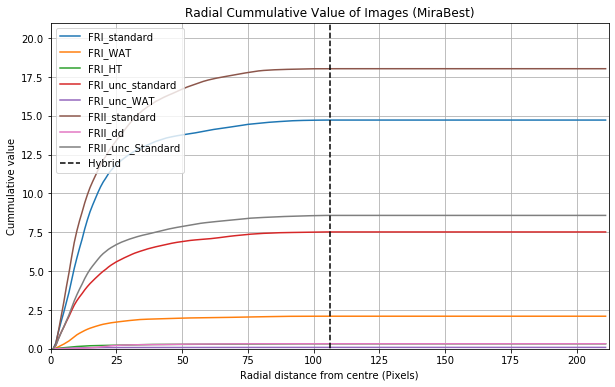

In [24]:
plt.figure(figsize=(10,6))
plt.title('Radial Cummulative Value of Images (MiraBest)')
plt.xlabel('Radial distance from centre (Pixels)')
plt.ylabel('Cummulative value')
plt.xlim(0,np.sqrt(150**2+150**2))
plt.ylim(0,21)
plt.grid()
for i in range(len(names_plot)-2):
    plt.plot(radii[i],list_plot_cum[i])
plt.plot(start,end,c='k',linestyle='dashed')
plt.legend(names_plot)
plt.show()
#print(
#f"""Images are normalised from 0 to 1.
#The average total brightness of each FRI image is:  {fri_cummulative[-1]:.1f}
#The average total brightness of each FRII image is: {frii_cummulative[-1]:.1f}""")

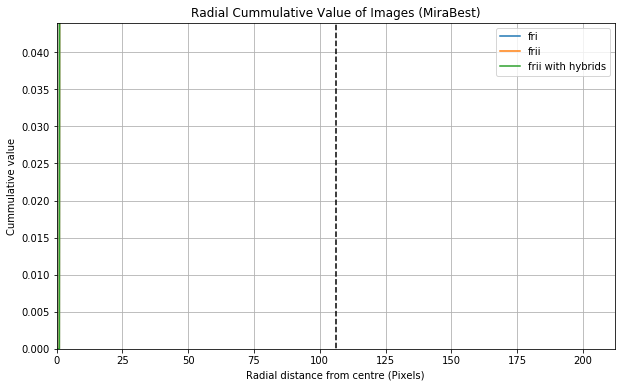

In [25]:

fri = np.sum(np.asarray(list_plot_cum[:5]),axis=0)
frii = np.sum(np.asarray(list_plot_cum[5:-2]),axis=0)
frii_w_Hybrid = np.sum(np.asarray(list_plot_cum[5:]),axis=0)
names = ['fri','frii','frii with hybrids']

plt.figure(figsize=(10,6))
plt.title('Radial Cummulative Value of Images (MiraBest)')
plt.plot(radii[0],fri)
plt.plot(radii[1],frii)
plt.plot(radii[2],frii_w_Hybrid)
plt.xlabel('Radial distance from centre (Pixels)')
plt.ylabel('Cummulative value')
plt.xlim(0,np.sqrt(150**2+150**2))
plt.ylim(0,0.044)
plt.grid()

plt.plot(start,end,c='k',linestyle='dashed')
plt.legend(names)
plt.show()
#print(
#f"""Images are normalised from 0 to 1.
#The average total brightness of each FRI image is:  {fri_cummulative[-1]:.1f}
#The average total brightness of each FRII image is: {frii_cummulative[-1]:.1f}""")